In [1]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import current
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path


class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = current.read(f, 'json')


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
            for cell in nb.worksheets[0].cells:
                if cell.cell_type == 'code' and cell.language == 'python':
                    # transform the input to executable Python
                    code = self.shell.input_transformer_manager.transform_cell(cell.input)
                    # run the code in themodule
                    exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod


class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

sys.meta_path.append(NotebookFinder())

from load_dataset import *
from adversarial_debiasing_model import *
from fairness_metrics import *

/anaconda3/lib/python3.7/site-packages/nbformat/current.py:19: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  """)


importing Jupyter notebook from load_dataset.ipynb
importing Jupyter notebook from adversarial_debiasing_model.ipynb
importing Jupyter notebook from fairness_metrics.ipynb


In [2]:
# Data Loading
filepath = "../data/Compas Dataset/processed_compas.csv"
label, protect = "is_recid", "race_African-American"

balanced = {"label_only":True,"downsample":True}
num_proxy_to_remove = 0
train_dataset, test_dataset = train_test_dataset(filepath, label, protect, 
                                                 is_scaled=True,
                                                 num_proxy_to_remove=num_proxy_to_remove,
                                                 balanced=balanced
                                                )

loaded
scaled
[[1477 1736]
 [1078 2135]]  balanced is_recid race_African-American
balanced


In [3]:
device = torch.device("cpu")

# Parameters and Hyperparameters
num_predictor_features = train_dataset[0][0].shape[0]
num_adversary_features = 1

hyperparams = {
"batch_size": 1000,
"num_epochs": 40,
"pred_lr_rate": 0.001,
"adv_lr_rate":0.001
}

# Data Loaders
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Models and Optimizers

def adversarial_training(hyperparams, alpha=0.1):
    torch.manual_seed(1)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=hyperparams["batch_size"], shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=hyperparams["batch_size"], shuffle=False)

    predictor = Predictor(num_predictor_features).to(device)
    adversary = Adversary(num_adversary_features).to(device)
    optimizer_P = optim.Adam(predictor.parameters(), lr=hyperparams["pred_lr_rate"])
    optimizer_A = optim.Adam(adversary.parameters(), lr=hyperparams["pred_lr_rate"])
    criterion = torch.nn.BCELoss()

    train_predictor_accuracies, train_adversary_accuracies = [], []
    test_predictor_accuracies, test_adversary_accuracies = [], []

    train_predictor_losses, train_adversary_losses = [], []
    test_predictor_losses, test_adversary_losses = [], []

    for epoch in range(1, hyperparams["num_epochs"] + 1):
        train_pred_loss, train_adv_loss, train_pred_accuracy, train_adv_accuracy = train(predictor, adversary, optimizer_P, optimizer_A, device, train_loader, criterion, epoch, alpha=alpha)
        train_predictor_losses.append(train_pred_loss)
        train_adversary_losses.append(train_adv_loss)
        train_predictor_accuracies.append(train_pred_accuracy)
        train_adversary_accuracies.append(train_adv_accuracy)

        test_pred_labels, test_pred_protect, test_pred_loss, test_adv_loss, test_pred_accuracy, test_adv_accuracy = test(predictor, adversary, device, test_loader, criterion)
        test_predictor_losses.append(test_pred_loss)
        test_adversary_losses.append(test_adv_loss)
        test_predictor_accuracies.append(test_pred_accuracy)
        test_adversary_accuracies.append(test_adv_accuracy)
    all_losses = [train_predictor_losses, train_adversary_losses, test_predictor_losses, test_adversary_losses]
    all_accuracies = [train_predictor_accuracies, train_adversary_accuracies, test_predictor_accuracies, test_adversary_accuracies]
    return train_loader, test_loader, test_pred_labels, train_pred_accuracy, test_pred_accuracy, all_losses, all_accuracies
train_loader, test_loader, test_pred_labels, train_pred_accuracy, test_pred_accuracy, losses, accuracies = adversarial_training(hyperparams)


/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")




Test set: Average loss: 8.66e-01, Predictor Accuracy: (46%), Adversary Accuracy: (62%)





Test set: Average loss: 8.65e-01, Predictor Accuracy: (47%), Adversary Accuracy: (62%)





Test set: Average loss: 8.64e-01, Predictor Accuracy: (49%), Adversary Accuracy: (62%)





Test set: Average loss: 8.63e-01, Predictor Accuracy: (53%), Adversary Accuracy: (62%)





Test set: Average loss: 8.61e-01, Predictor Accuracy: (53%), Adversary Accuracy: (62%)





Test set: Average loss: 8.60e-01, Predictor Accuracy: (54%), Adversary Accuracy: (62%)





Test set: Average loss: 8.59e-01, Predictor Accuracy: (55%), Adversary Accuracy: (62%)





Test set: Average loss: 8.58e-01, Predictor Accuracy: (55%), Adversary Accuracy: (62%)





Test set: Average loss: 8.57e-01, Predictor Accuracy: (56%), Adversary Accuracy: (62%)





Test set: Average loss: 8.56e-01, Predictor Accuracy: (56%), Adversary Accuracy: (62%)





Test set: Average loss: 8.55e-01, Predictor Accuracy: (57%), Adversary Accuracy: (62%)





Test set: Average loss: 8.54e-01, Predictor Accuracy: (58%), Adversary Accuracy: (62%)





Test set: Average loss: 8.54e-01, Predictor Accuracy: (58%), Adversary Accuracy: (62%)





Test set: Average loss: 8.53e-01, Predictor Accuracy: (58%), Adversary Accuracy: (62%)





Test set: Average loss: 8.52e-01, Predictor Accuracy: (58%), Adversary Accuracy: (62%)





Test set: Average loss: 8.51e-01, Predictor Accuracy: (58%), Adversary Accuracy: (62%)





Test set: Average loss: 8.50e-01, Predictor Accuracy: (58%), Adversary Accuracy: (62%)





Test set: Average loss: 8.49e-01, Predictor Accuracy: (59%), Adversary Accuracy: (62%)





Test set: Average loss: 8.48e-01, Predictor Accuracy: (59%), Adversary Accuracy: (62%)





Test set: Average loss: 8.47e-01, Predictor Accuracy: (59%), Adversary Accuracy: (62%)





Test set: Average loss: 8.47e-01, Predictor Accuracy: (59%), Adversary Accuracy: (62%)





Test set: Average loss: 8.46e-01, Predictor Accuracy: (59%), Adversary Accuracy: (62%)





Test set: Average loss: 8.45e-01, Predictor Accuracy: (60%), Adversary Accuracy: (62%)





Test set: Average loss: 8.44e-01, Predictor Accuracy: (60%), Adversary Accuracy: (62%)





Test set: Average loss: 8.43e-01, Predictor Accuracy: (61%), Adversary Accuracy: (62%)





Test set: Average loss: 8.42e-01, Predictor Accuracy: (61%), Adversary Accuracy: (62%)





Test set: Average loss: 8.42e-01, Predictor Accuracy: (61%), Adversary Accuracy: (62%)





Test set: Average loss: 8.41e-01, Predictor Accuracy: (62%), Adversary Accuracy: (62%)





Test set: Average loss: 8.40e-01, Predictor Accuracy: (62%), Adversary Accuracy: (62%)





Test set: Average loss: 8.39e-01, Predictor Accuracy: (62%), Adversary Accuracy: (62%)





Test set: Average loss: 8.39e-01, Predictor Accuracy: (62%), Adversary Accuracy: (62%)





Test set: Average loss: 8.38e-01, Predictor Accuracy: (62%), Adversary Accuracy: (62%)





Test set: Average loss: 8.37e-01, Predictor Accuracy: (62%), Adversary Accuracy: (62%)





Test set: Average loss: 8.36e-01, Predictor Accuracy: (62%), Adversary Accuracy: (62%)





Test set: Average loss: 8.36e-01, Predictor Accuracy: (63%), Adversary Accuracy: (62%)





Test set: Average loss: 8.35e-01, Predictor Accuracy: (63%), Adversary Accuracy: (62%)





Test set: Average loss: 8.34e-01, Predictor Accuracy: (63%), Adversary Accuracy: (62%)





Test set: Average loss: 8.33e-01, Predictor Accuracy: (63%), Adversary Accuracy: (62%)





Test set: Average loss: 8.33e-01, Predictor Accuracy: (63%), Adversary Accuracy: (62%)





Test set: Average loss: 8.32e-01, Predictor Accuracy: (63%), Adversary Accuracy: (62%)



/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


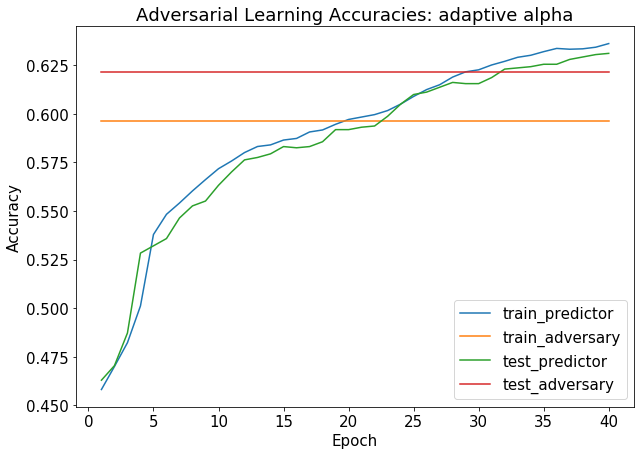

In [4]:
import matplotlib
font = {'family' : 'normal',
        'size': 15}
matplotlib.rc('font', **font)
epochs = range(1, hyperparams["num_epochs"] + 1)
plt.figure(figsize=(10,7))
plt.plot(epochs, accuracies[0], label="train_predictor")
plt.plot(epochs, accuracies[1], label="train_adversary")
plt.plot(epochs, accuracies[2], label="test_predictor")
plt.plot(epochs, accuracies[3], label="test_adversary")
plt.title("Adversarial Learning Accuracies: adaptive alpha")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("../plots/adversarial_model/accuracy_against_epoch.png")
plt.show()

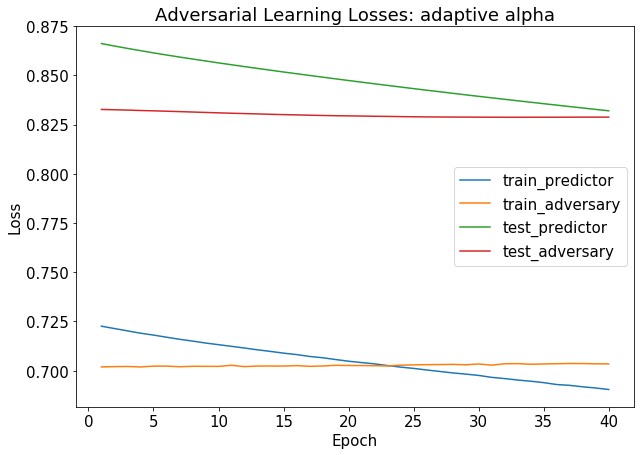

In [5]:
plt.figure(figsize=(10,7))
plt.plot(epochs, losses[0], label="train_predictor")
plt.plot(epochs, losses[1], label="train_adversary")
plt.plot(epochs, losses[2], label="test_predictor")
plt.plot(epochs, losses[3], label="test_adversary")
plt.title("Adversarial Learning Losses: adaptive alpha")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("../plots/adversarial_model/loss_against_epoch.png")
plt.show()

In [6]:
###### Fairness Metrics
print("Simple Logistic Model")

black_confusion_matrix = binary_confusion_matrix(test_loader.dataset.label, test_pred_labels, test_loader.dataset.protect, 1)
white_confusion_matrix = binary_confusion_matrix(test_loader.dataset.label, test_pred_labels, test_loader.dataset.protect, 0)

black_fpr = false_positive_rate(black_confusion_matrix)
white_fpr = false_positive_rate(white_confusion_matrix)


black_fnr = false_negative_rate(black_confusion_matrix)
white_fnr = false_negative_rate(white_confusion_matrix)

# print(train_accuracy, "Train Acuuracy")
# print(test_accuracy, "Test Acuuracy")

print(black_confusion_matrix, " Blacks")
print(white_confusion_matrix, " Whites")

print(frac_predicted_positive(black_confusion_matrix), frac_predicted_positive(white_confusion_matrix), "Fraction predicted positive females, males")
print(statistical_parity_difference(black_confusion_matrix, white_confusion_matrix), " statistical_parity_difference")

print(black_fpr - white_fpr, "FPR difference")
print(black_fnr - white_fnr, "FNR difference")

# print(female_fnr, male_fnr, " FNR Blacks, Whites")
# print(female_fpr, male_fpr, " FPR Blacks, Whites")
print(true_positive_rate_difference(black_confusion_matrix, white_confusion_matrix), " true_positive_rate_difference")
print(false_positive_rate_difference(black_confusion_matrix, white_confusion_matrix), " false_positive_rate_difference")
print(average_odds_difference(black_confusion_matrix, white_confusion_matrix), " average_odds_difference")


Simple Logistic Model
[[216 241]
 [122 420]]  Blacks
[[207 142]
 [ 88 171]]  Whites
0.6616616616616616 0.5148026315789473 Fraction predicted positive females, males
0.14685903008271428  statistical_parity_difference
0.12047550676205226 FPR difference
-0.11467608884583053 FNR difference
0.11467608884583047  true_positive_rate_difference
0.12047550676205226  false_positive_rate_difference
0.11757579780394137  average_odds_difference


In [7]:
def fainess_vs_accuracy(hyperparams, alphas):
    test_accurcies, test_fairness = [], []
    for alpha in alphas:
        _, test_loader, test_pred_labels, train_pred_accuracy, test_pred_accuracy,_,_ = adversarial_training(hyperparams, alpha)
        female_confusion_matrix = binary_confusion_matrix(test_loader.dataset.label, test_pred_labels, test_loader.dataset.protect, 0)
        male_confusion_matrix = binary_confusion_matrix(test_loader.dataset.label, test_pred_labels, test_loader.dataset.protect, 1)

        female_fpr = false_positive_rate(female_confusion_matrix)
        male_fpr = false_positive_rate(male_confusion_matrix)


        female_fnr = false_negative_rate(female_confusion_matrix)
        male_fnr = false_negative_rate(male_confusion_matrix)
        
        avg_odds_diff = average_odds_difference(female_confusion_matrix, male_confusion_matrix)
        test_accurcies.append(test_pred_accuracy)
        test_fairness.append(avg_odds_diff)
    return test_accurcies, test_fairness  

alphas = [10**i for i in [-2,-1,0,1,2]]   
hyperparams = {
"batch_size": 1000,
"num_epochs": 15,
"pred_lr_rate": 0.001,
"adv_lr_rate":0.001
}

# test_accurcies, test_fairness = fainess_vs_accuracy(hyperparams, alphas)   

In [8]:
# plt.figure(figsize=(10,7))
# plt.plot(alphas, test_accurcies, marker='o', label="test_accuracy")
# plt.plot(alphas, test_fairness, marker='o', label="test_avg_odds_difference")
# plt.xlabel("alpha")
# plt.ylabel("Average Odds/Accuracy")
# plt.title("Fairness Accuracy Tradeoff: changing alpha")

# plt.legend()
# plt.xscale('log', basex=10)
# plt.savefig("../plots/adversarial_model/fairness_accuracy_against_alpha")
    